## 第8章，红楼梦文本聚类

In [1]:
## 加载所需要包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer

## 设置字体
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)
## 引入3D坐标系
from mpl_toolkits.mplot3d import Axes3D
## 设置pandas显示方式
pd.set_option("display.max_rows",8)

pd.options.mode.chained_assignment = None  # default='warn'

## 设置显示图像的方式
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
## 读取停用词
stopword = pd.read_csv("data/chap8/Readream/红楼梦停用词.txt",
                       header=None,names = ["Stopwords"])
## 读取红楼梦数据集
Red_df = pd.read_excel("data/chap8/Readream/红楼梦数据集.xlsx")
Red_df.head(5)

,Chapter,ChapName,Artical
0,第一回,"甄士隐梦幻识通灵,贾雨村风尘怀闺秀",此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<石头...
1,第二回,"贾夫人仙逝扬州城,冷子兴演说荣国府",诗云一局输赢料不真，香销茶尽尚逡巡。欲知目下兴衰兆，须问旁观冷眼人。却说封肃因听见公差传唤，...
2,第三回,"贾雨村夤缘复旧职,林黛玉抛父进京都",却说雨村忙回头看时，不是别人，乃是当日同僚一案参革的号张如圭者。他本系此地人，革后家居，今打...
3,第四回,"薄命女偏逢薄命郎,葫芦僧乱判葫芦案",却说黛玉同姊妹们至王夫人处，见王夫人与兄嫂处的来使计议家务，又说姨母家遭人命官司等语。因见王...
4,第五回,"游幻境指迷十二钗,饮仙醪曲演红楼梦",第四回中既将薛家母子在荣府内寄居等事略已表明，此回则暂不能写矣。如今且说林黛玉自在荣府以来，...


###  分词

In [5]:
import jieba

In [6]:
list(jieba.cut(Red_df.ChapName[2], cut_all=True))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/bh/xgh997m97vl8yvm3sxvwfr5r0000gn/T/jieba.cache
Loading model cost 0.820 seconds.
Prefix dict has been built succesfully.


['贾雨村', '夤缘', '复旧', '职', '', '', '林黛玉', '抛', '父', '进京', '京都']

In [7]:
list(jieba.cut(Red_df.ChapName[2]))

['贾雨村', '夤缘', '复旧', '职', ',', '林黛玉', '抛父', '进京', '都']

In [8]:
## 添加自定义词典
jieba.load_userdict("data/chap8/Readream/红楼梦词典.txt")

In [9]:
list(jieba.cut(Red_df.ChapName[2], cut_all=True))

['贾雨村',
 '贾雨村夤缘复旧职',
 '夤缘',
 '复旧',
 '职',
 '',
 '',
 '林黛玉',
 '林黛玉抛父进京都',
 '黛玉',
 '抛',
 '父',
 '进京',
 '京都']

In [10]:
list(jieba.cut(Red_df.ChapName[2]))

['贾雨村夤缘复旧职', ',', '林黛玉抛父进京都']

In [11]:
## 对红楼梦全文进行分词
## 数据表的行数
row,col = Red_df.shape
## 预定义列表
Red_df["cutword"] = "cutword"
for ii in np.arange(row):
    ## 分词
    cutwords = list(jieba.cut(Red_df.Artical[ii], cut_all=True))
    ## 去除长度为1的词
    cutwords = pd.Series(cutwords)[pd.Series(cutwords).apply(len)>1]
    ## 去停用词
    cutwords = cutwords[~cutwords.isin(stopword)]
    Red_df.cutword[ii] = cutwords.values

In [12]:
## 查看全文的分词结果
Red_df.cutword[1:5]

1    [诗云, 一局, 输赢, 逡巡, 欲知目下兴衰兆, 目下, 兴衰, 须问旁观冷眼人, 旁观,...
2    [却说, 回头, 不是, 别人, 乃是, 当日, 同僚, 一案, 张如圭, 本系, 此地, ...
3    [却说, 黛玉, 姊妹, 王夫人, 夫人, 王夫人, 夫人, 兄嫂, 计议, 家务, 姨母,...
4    [第四, 第四回, 四回, 回中, 家母, 母子, 荣府, 荣府内, 寄居, 事略, 表明,...
Name: cutword, dtype: object

### LDA主题模型

使用gensim库中的模型

In [13]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

In [14]:
## 将分好的词语和它对应的ID规范化封装
dictionary = Dictionary(Red_df.cutword)
## 将单词集合转换为（word_id，word_frequency）2元组的表示形式列表。
corpus = [dictionary.doc2bow(word) for word in Red_df.cutword]
## LDA主题模型
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4,random_state=12)

In [15]:
## 输出其中的几个主题
lda.print_topics(2)

[(2,
  '0.013*"宝玉" + 0.008*"太太" + 0.008*"贾母" + 0.007*"一个" + 0.006*"夫人" + 0.006*"什么" + 0.006*"凤姐" + 0.006*"我们" + 0.005*"宝钗" + 0.005*"黛玉"'),
 (3,
  '0.016*"宝玉" + 0.009*"什么" + 0.008*"凤姐" + 0.007*"太太" + 0.005*"夫人" + 0.005*"一个" + 0.005*"起来" + 0.005*"贾母" + 0.005*"姑娘" + 0.005*"那里"')]

In [17]:
## 主题模型可视化
import pyLDAvis
import pyLDAvis.gensim
red_vis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(red_vis_data)

In [18]:
## 主题模型可视化
red_vis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary,mds="tsne")
pyLDAvis.display(red_vis_data)

In [16]:
## 得到每一章节所属的类
clust = []
for cutword in Red_df.cutword:
    bow = dictionary.doc2bow(cutword)
    t = np.array(lda.get_document_topics(bow))
    ## 输出最有可能的类
    index = t[:,1].argsort()[-1]
    clust.append(t[index,:])
    
cluster = pd.DataFrame(clust,columns=["cluster","probability"])
print(cluster.head(5))

   cluster  probability
0      1.0     0.824323
1      1.0     0.904036
2      1.0     0.917593
3      2.0     0.756430
4      3.0     0.999652


In [17]:
cluster.cluster.value_counts()

2.0    59
3.0    46
1.0    11
0.0     4
Name: cluster, dtype: int64

### 计算TFIDF，并使用它对文章进行系统聚类分析

In [18]:
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram,linkage

In [19]:
## 准备工作，将分词后的结果整理成，CountVectorizer（）可应用的形式
## 将所有分词后的结果使用空格连接为字符串，并组成列表，每一段为列表中的一个元素
articals = []
for cutword in Red_df.cutword:
    cutword = [s for s in cutword if len(s) < 5]
    cutword = " ".join(cutword)
    articals.append(cutword)

In [20]:
## 构建语料库，并计算文档－－词的TF－IDF矩阵
## max_features参数根据出现的频率排序，只取指定的数目
vectorizer = CountVectorizer(max_features=2000)    
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(articals))
tfidf

<120x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 66303 stored elements in Compressed Sparse Row format>

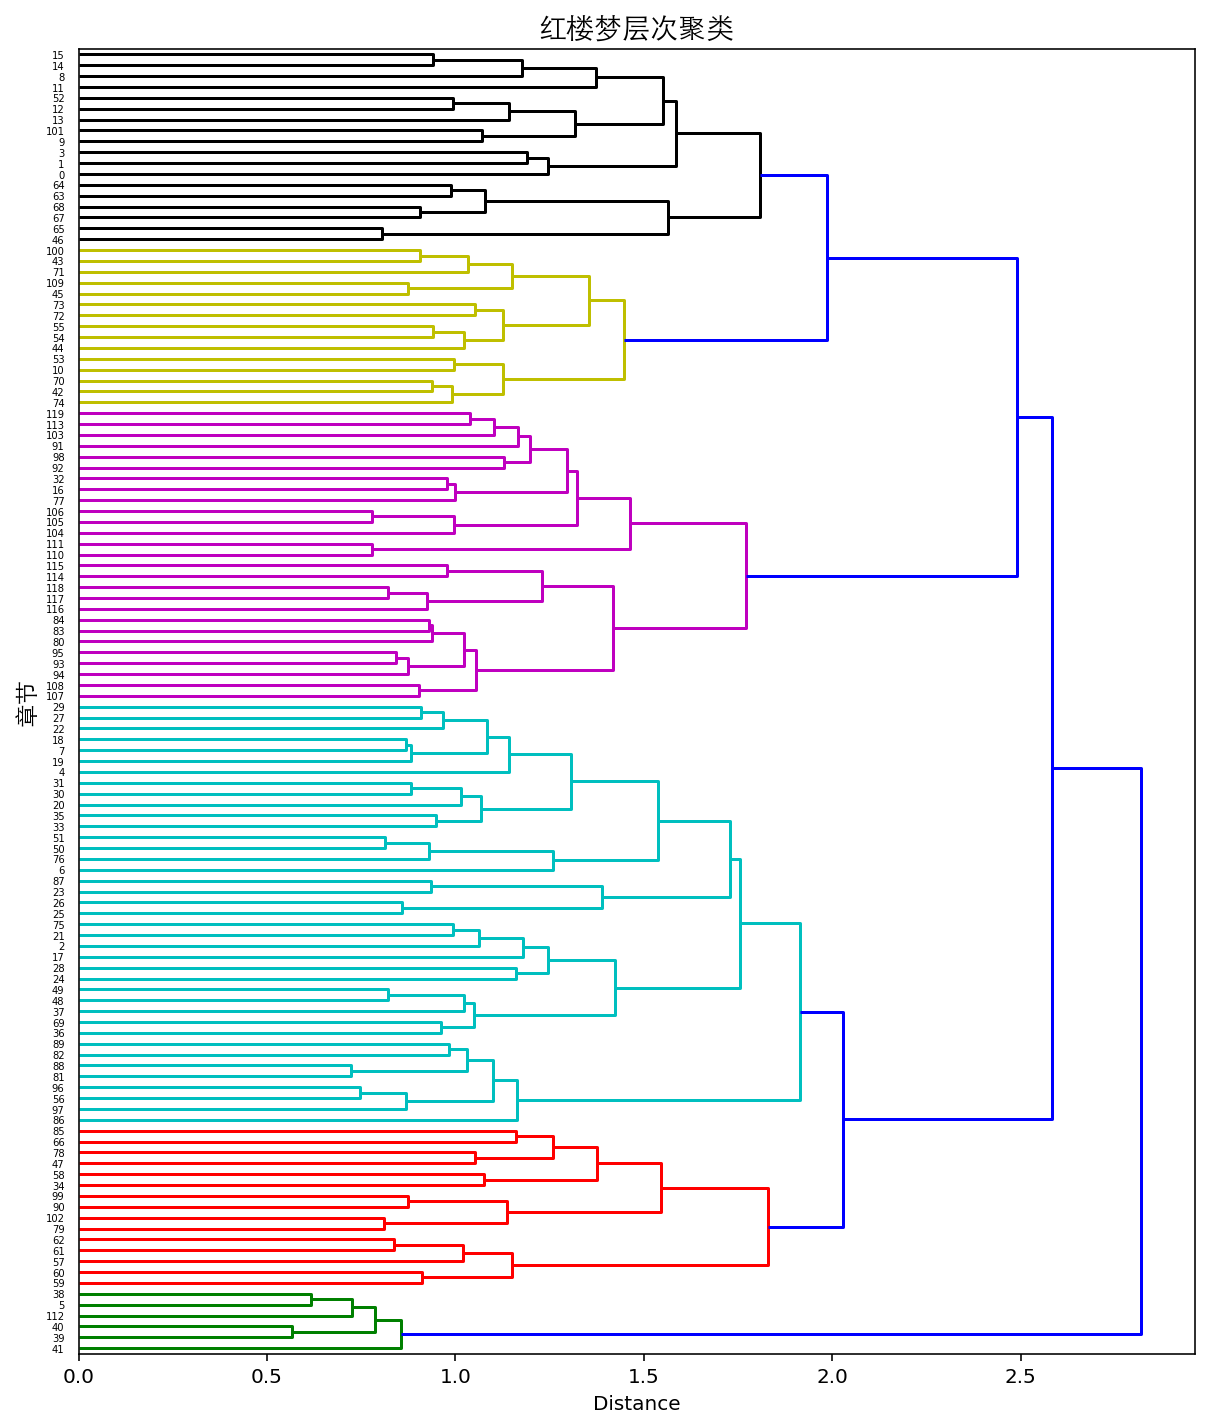

In [21]:
## 对数据进行系统聚类并绘制树
X = tfidf.toarray()
Z = linkage(X, method='ward', metric='euclidean', )
fig = plt.figure(figsize=(10,12))
reddn = dendrogram(Z,orientation='right')
plt.title("红楼梦层次聚类",fontproperties = fonts)
plt.ylabel("章节",fontproperties = fonts,size=12)
plt.xlabel("Distance")
plt.show()

In [22]:
## 使用T-Sne降维然后数据可视化
## 降维为2维
X = tfidf.toarray()
tsne = TSNE(n_components=2, random_state=1233)
X_tsne = tsne.fit_transform(X)

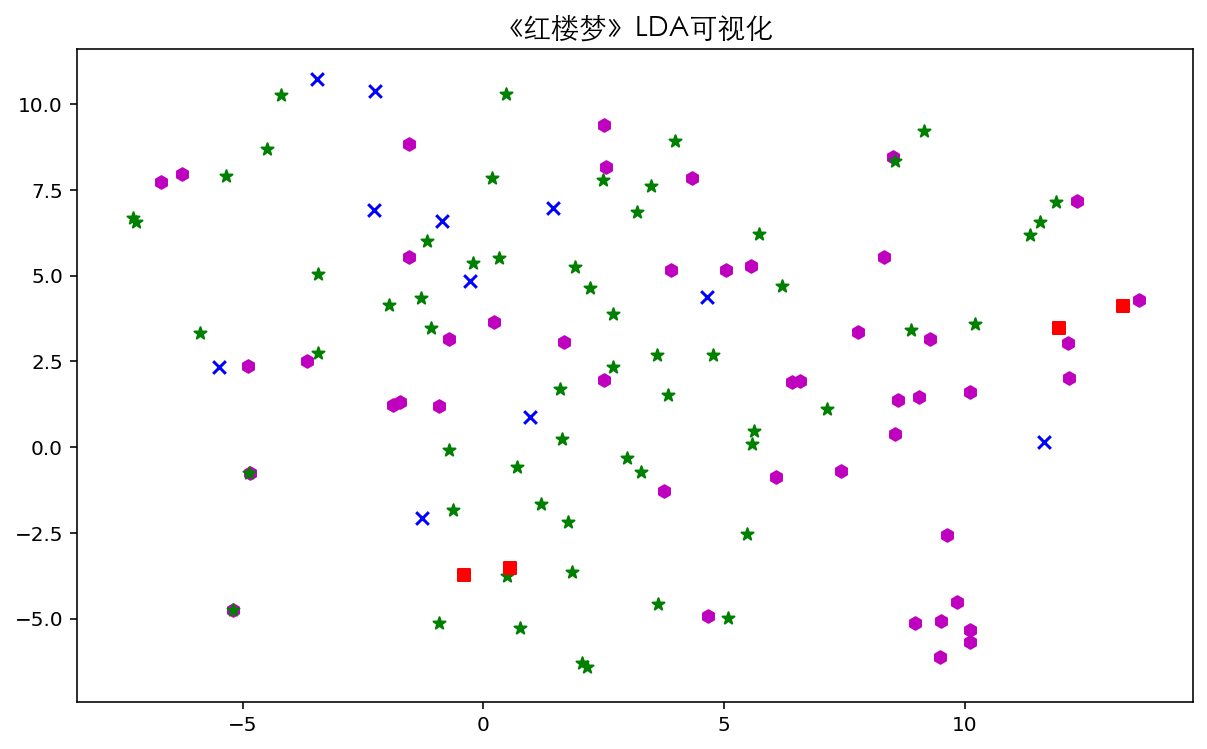

In [23]:
## 可视化
shape = ["s","x","*","h","+","p","D","o","v",">"]
color = ["r","b","g","m"]
plt.figure(figsize=(10,6))
for ii in range(120):
    cla = int(cluster.cluster.values[ii])
    plt.scatter(X_tsne[ii,0],X_tsne[ii,1],c=color[cla],marker = shape[cla],s = 40)
plt.title("《红楼梦》LDA可视化",FontProperties = fonts)
plt.show()


### 分析红楼梦的人物关系

In [24]:
## 查看几个关键人物在整个书籍中的出现次数的变化
## 读取红楼梦中人物名数据集
role = pd.read_csv("data/chap8/Readream/红楼梦人物.txt",header=None,names = ["rolename"])
role.head()

,rolename
0,艾官
1,安国公
2,白老媳妇
3,白老媳妇儿
4,白玉钏


In [25]:
## 计算每个角色在书籍中出现的次数
# 将120章的分词结果连接在一起,并计算词频
allcutword = np.concatenate(Red_df.cutword)
allcutword = pd.DataFrame({"word":allcutword})
allcutword = allcutword.groupby(by=["word"])["word"].agg(number= ("value",np.size))
allcutword = allcutword.reset_index().sort_values(by="number",ascending=False)


In [26]:
## 计算人物所出现的次数
counts = []
for ii in role.index:
    rolenam = role.rolename[ii]
    number = allcutword["number"][allcutword.word == rolenam]
    counts.append(number.values)

role["counts"] = pd.DataFrame(counts)

In [27]:
## 去除缺失值 和出现次数小于5的人物
role = role[role.counts.notnull()].sort_values(by="counts",ascending=False)
role = role[role.counts > 5].reset_index(drop=True)
print(role.head())

  rolename  counts
0       宝玉  3862.0
1       凤姐  1680.0
2       贾母  1639.0
3       袭人  1123.0
4      王夫人  1039.0


In [28]:
print(role.head())

  rolename  counts
0       宝玉  3862.0
1       凤姐  1680.0
2       贾母  1639.0
3       袭人  1123.0
4      王夫人  1039.0


In [29]:
## 查看前几个关键人物在各章节的走势
rolenumber = np.zeros((10,120))
for kk in np.arange(10):
    # 计算每个人物在各章节出现的次数
    nums = []
    for ii in np.arange(len(Red_df.index)):
        ## 每章节词频
        chapcutword= pd.DataFrame({"word":Red_df.cutword[ii]})
        chapcutword = chapcutword.groupby(by=["word"])["word"].agg(number= ("value",np.size))
        chapcutword = chapcutword.reset_index()
        #  一个章节出现次数
        num = chapcutword["number"][chapcutword.word == role.rolename[kk]]
        nums.append(num.values)
    # 一个人的所有章节出现次数
    rolenumber[kk,:] = pd.DataFrame(nums).fillna(0).values[:,0]

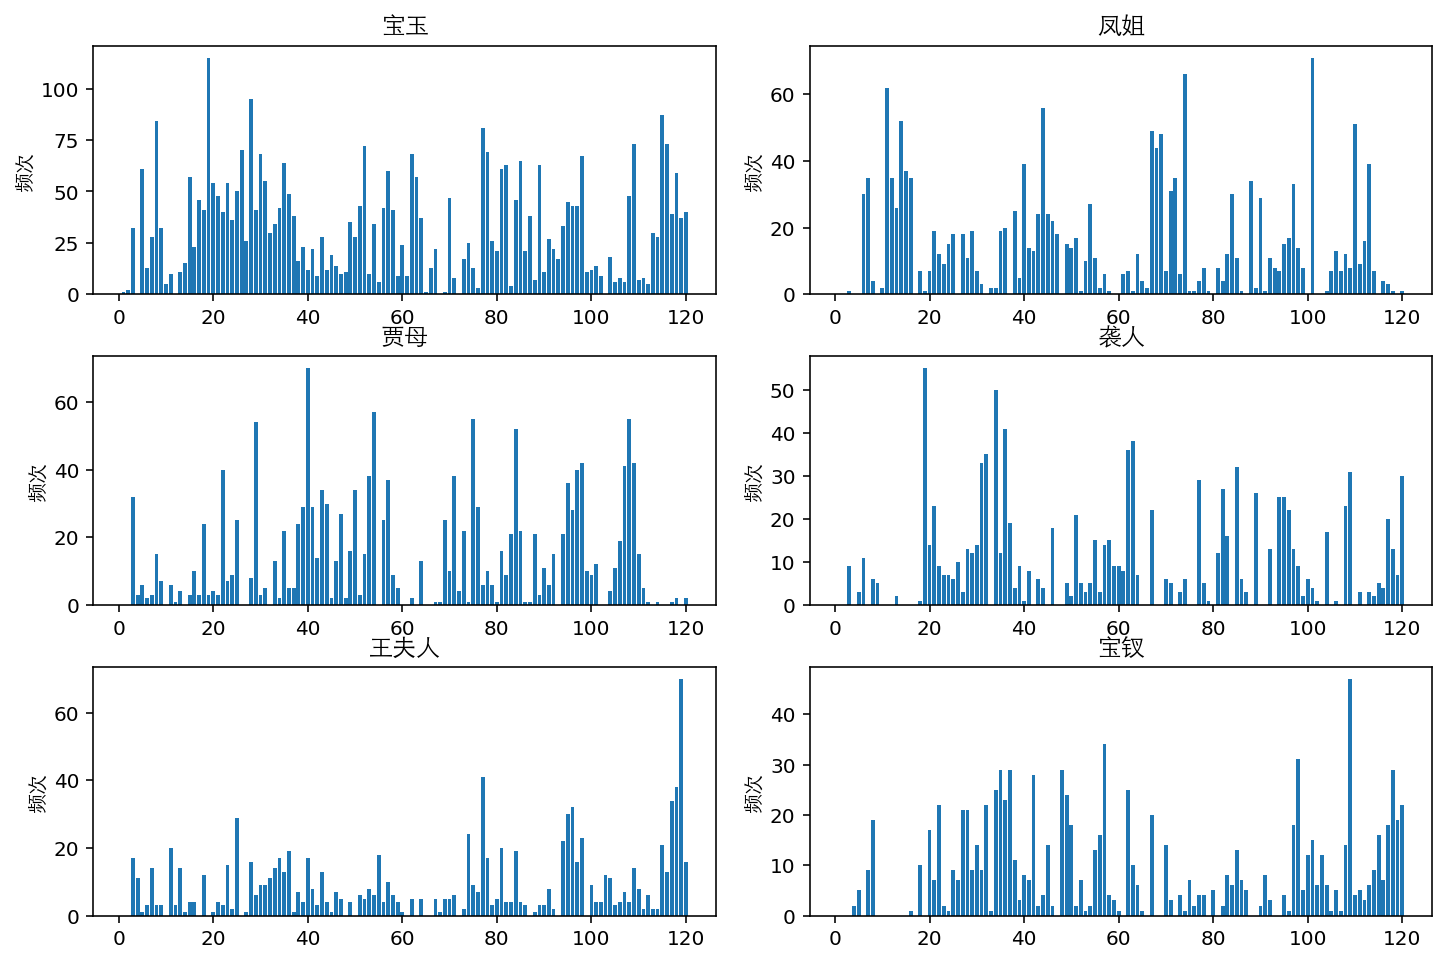

In [30]:
## 绘制人物在各个章节出场频次变化图
plt.figure(figsize=(12,8))
for ii in np.arange(6):
    plt.subplot(3,2,ii+1)
    plt.bar(np.arange(120)+1,rolenumber[ii,:],alpha = 1)
    plt.title(role.rolename[ii],FontProperties = fonts,size = 12)
    plt.ylabel("频次",FontProperties = fonts,size = 10)
plt.subplots_adjust(hspace = 0.25,wspace = 0.15)
plt.show()

/Users/daitu/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/daitu/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/daitu/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/daitu/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/daitu/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36158 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/daitu/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py

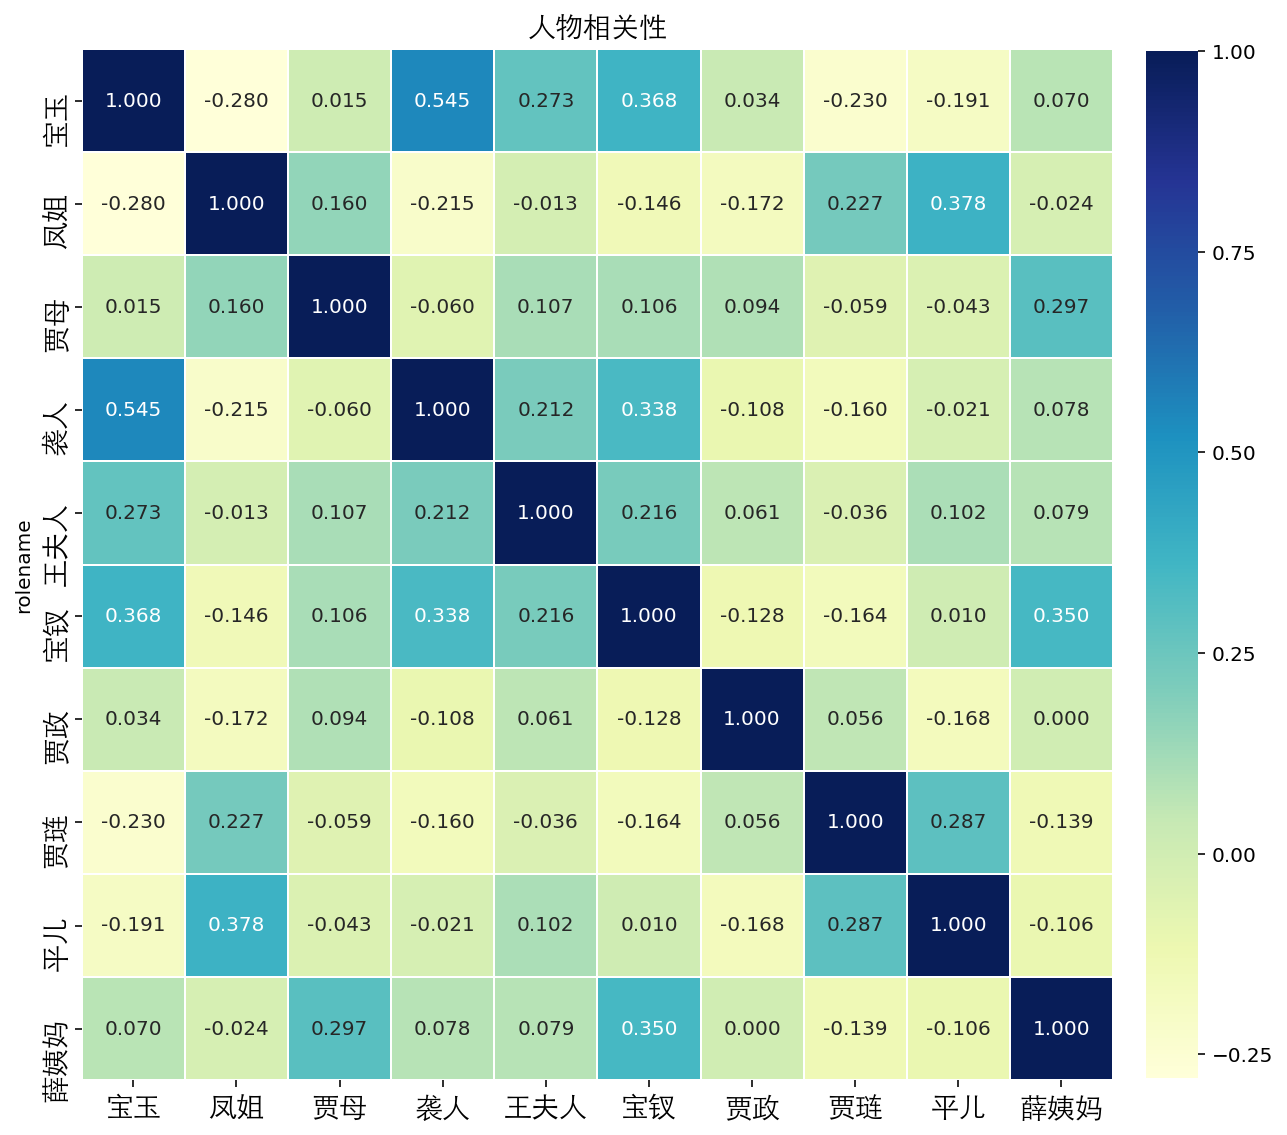

In [36]:
## 分析10个人出场的相关性
import seaborn as sns
datacor = np.corrcoef(rolenumber)
datacor = pd.DataFrame(data=datacor,columns=role.rolename[0:10],index=role.rolename[0:10])
## 相关稀疏热力图
plt.figure(figsize=(10,10))
ax = sns.heatmap(datacor,square=True,annot=True,fmt = ".3f",
                 linewidths=.5,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03})
ax.set_xticklabels(role.rolename[0:10],fontproperties = fonts)
ax.set_yticklabels(role.rolename[0:10],fontproperties = fonts)
ax.set_title("人物相关性",fontproperties = fonts)
ax.set_xlabel("")
ax.set_xlabel("")
plt.show()

In [52]:
## 根据分词结果，计算人物之间的关系权重,值分析人物出场次数大于100次的人物
## 权重的定义，如果两个人物同时出现在同一章节中，则相应的权重增加1
Red_df.cutword

0      [开卷, 第一, 第一回, 一回, 作者, 一番, 梦幻, 之后, 真事, 隐去, 之说, ...
1      [诗云, 一局, 输赢, 逡巡, 欲知目下兴衰兆, 目下, 兴衰, 须问旁观冷眼人, 旁观,...
2      [却说, 回头, 不是, 别人, 乃是, 当日, 同僚, 一案, 张如圭, 本系, 此地, ...
3      [却说, 黛玉, 姊妹, 王夫人, 夫人, 王夫人, 夫人, 兄嫂, 计议, 家务, 姨母,...
                             ...                        
116    [王夫人, 夫人, 打发, 发人, 宝钗, 过去, 商量, 宝玉, 听见, 和尚, 在外, ...
117    [说话, 邢王二, 王二夫人, 夫人, 尤氏, 一段, 一段话, 明知, 挽回, 王夫人, ...
118    [莺儿, 宝玉, 说话, 摸不着, 摸不着头脑, 不着, 头脑, 听宝玉, 宝玉, 说道, ...
119    [宝钗, 秋纹, 袭人, 不好, 连忙, 进去, 巧姐, 巧姐儿, 姐儿, 平儿, 随着, ...
Name: cutword, Length: 120, dtype: object

In [53]:
rolenew = role[role.counts>100]
rolenew

,rolename,counts
0,宝玉,3862.0
1,凤姐,1680.0
2,贾母,1639.0
3,袭人,1123.0
...,...,...
37,莺儿,126.0
38,赵姨娘,122.0
39,宝蟾,114.0
40,巧姐,107.0


In [54]:
## 构建两两之间的关系
from itertools import combinations
relation = combinations(rolenew.rolename,2)

In [55]:
rela = []
weight  = []
for ii in relation:
    rela.append(ii)
    ## 计算两者是之间的权重
    weig = 0
    for kk in np.arange(len(Red_df.index)):
        ## 人物是否同时出现在同一章
        if ((sum(Red_df.cutword[kk] == ii[0]) >1) & (sum(Red_df.cutword[kk] == ii[1]) >1)):
            weig = weig+1
    weight.append(weig)

In [56]:
Red_rela = pd.DataFrame(rela)
Red_rela.columns = ["First","Second"]
Red_rela["weight"] = weight
Red_rela = Red_rela[Red_rela.weight>20].sort_values(by="weight",ascending=False).reset_index(drop = True)
print(Red_rela.head())

  First Second  weight
0    宝玉    王夫人      91
1    宝玉     贾母      87
2    宝玉     凤姐      83
3    宝玉     宝钗      83
4    宝玉     袭人      81


In [57]:
print(Red_rela.head())

  First Second  weight
0    宝玉    王夫人      91
1    宝玉     贾母      87
2    宝玉     凤姐      83
3    宝玉     宝钗      83
4    宝玉     袭人      81


In [58]:
import networkx as nx

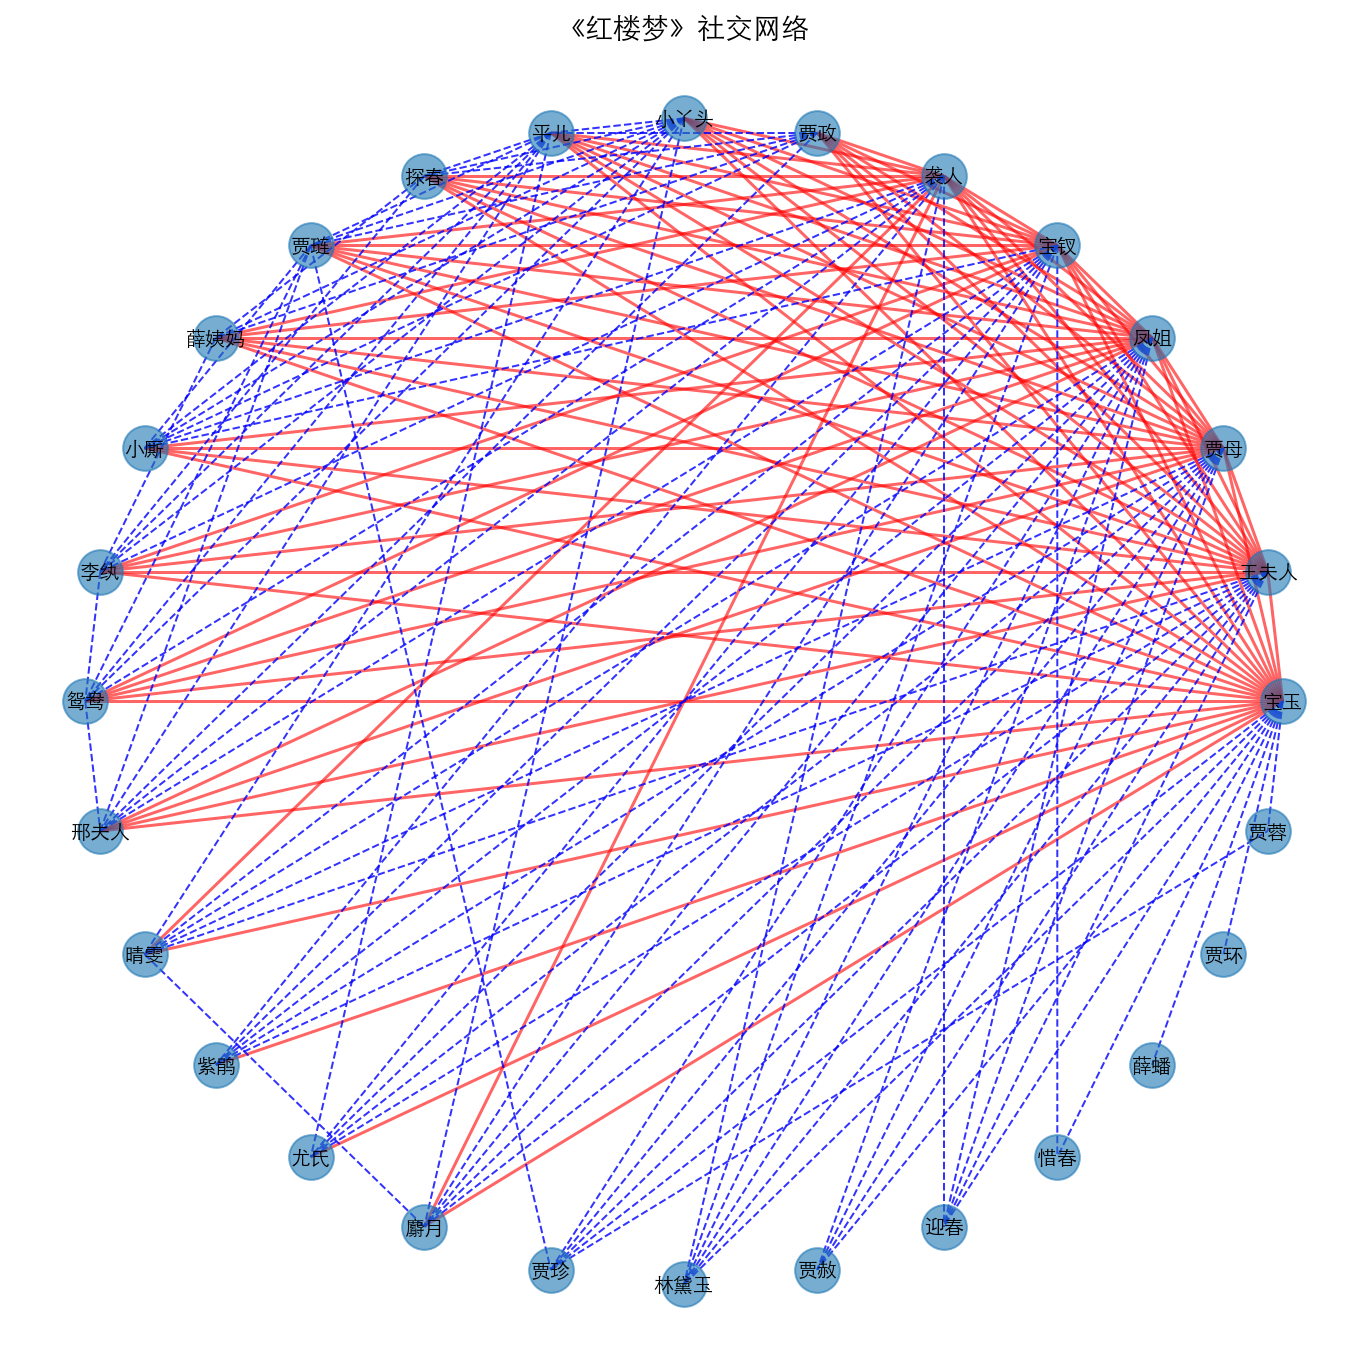

In [59]:
## 将人物关系可视化
plt.figure(figsize=(12,12))
## 生成社交网络图
G=nx.Graph()

## 添加边
for ii in Red_rela.index:
    G.add_edge(Red_rela.First[ii],Red_rela.Second[ii],weight = Red_rela.weight[ii] / 120)
    
## 定义两种边
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.25]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.25]

## 图的布局
pos=nx.circular_layout(G) # positions for all nodes

# nodes根据
nx.draw_networkx_nodes(G,pos,alpha=0.6,node_size=500)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=1.5,alpha=0.6,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.8,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family="STHeiti")

plt.axis('off')
plt.title("《红楼梦》社交网络",FontProperties = fonts)
plt.show() # display

In [60]:
## 计算每个节点的度
Red_degree = pd.DataFrame(list(G.degree))
Red_degree.columns = ["name","degree"]
Red_degree

,name,degree
0,宝玉,27
1,王夫人,23
2,贾母,23
3,凤姐,23
...,...,...
24,惜春,2
25,薛蟠,1
26,贾环,1
27,贾蓉,2


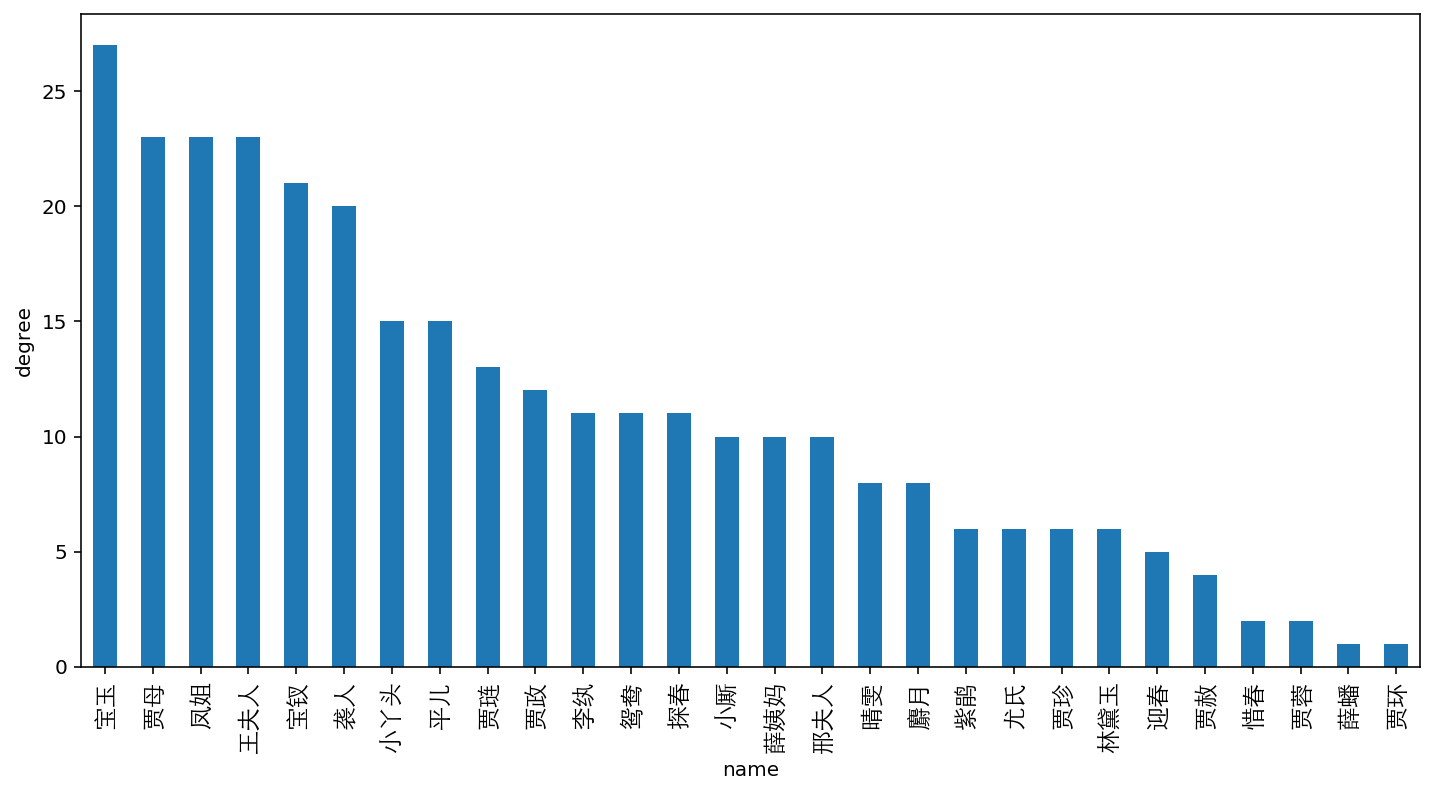

In [61]:
Red_degree.sort_values(by="degree",ascending=False).plot(kind = "bar",x="name",y = "degree",figsize=(12,6),legend=False)
plt.xticks(FontProperties = fonts,size = 12)
plt.ylabel("degree")
plt.show()